In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial 8: In silico Saturation Mutagenesis (ISM)

> predict + ersatz (substitute) + predict

In silico marginalizations show the effect on model predictions that each motif has, marginalized over a large number of background regions; in contrast, <i>in silico saturation mutagenesis</i> (ISM) shows that influence that each <i>character</i> has within an <i>endogenous</i> sequence context. Basically, rather than creating ersatz sequences containing the motif and running them through a model, ISM allows one to evaluate drivers of predictions in real sequences. At a high level, ISM operates by changing the character at each position to each other potential character, one at a time, and evaluating the difference in prediction between the new character and the original character at that position. This difference is interpreted as a form of importance/attribution, with a higher magnitude value meaning that changing the character has a large impact and is likely very important.

Like other functions in `tangermeme`, this function does not impose a specific distance measure between the predictions from the original and mutated sequences. Rather, the function will return the predictions on the original sequences as well as the prediction in each sequence given each individual mutation, and the user can apply whatever distance function they would like on those values themselves. This allows users to try out various distance functions or handle more complex cases, such as when the model yields multiple outputs.

Let's demonstrate how to use this using Beluga / DeepSEA.

In [2]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))
model.eval()

Beluga(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(320, 320, kernel_size=(1, 8), stride=(1, 1))
      (3): ReLU()
      (4): Dropout(p=0.2, inplace=False)
      (5): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
      (7): ReLU()
      (8): Conv2d(480, 480, kernel_size=(1, 8), stride=(1, 1))
      (9): ReLU()
      (10): Dropout(p=0.2, inplace=False)
      (11): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(480, 640, kernel_size=(1, 8), stride=(1, 1))
      (13): ReLU()
      (14): Conv2d(640, 640, kernel_size=(1, 8), stride=(1, 1))
      (15): ReLU()
    )
    (1): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Lambda()
      (2): Sequential(
        (0): Lambda()
        (1): Linear(in_features=67840, out_features

Then, we need a sequence to analyze. Here, we will generate an ersatz sequence with a known motif in middle so that we know what we are looking for. In practice, you probably would like to use a sequence from a reference sequence and known construct. 

In [3]:
from tangermeme.utils import random_one_hot
from tangermeme.ersatz import substitute

X = random_one_hot((1, 4, 2000)).type(torch.float32)
X = substitute(X, "CTCAGTGATG")

We can run ISM on a sequence (or a batch of sequences) using the `saturation_mutagenesis` function. This function takes in a model, the batch of sequences, and a few other arguments, and returns the original predictions as well as the predictions on each mutation. Because it is built on the `predict` method, all of benefits of that core function are available here as well.

In [4]:
from tangermeme.ism import saturation_mutagenesis

y_ref, y_ism = saturation_mutagenesis(model, X, device='cpu')
y_ref.shape, y_ism.shape

(torch.Size([1, 2002]), torch.Size([1, 4, 2000, 2002]))

This function has two outputs: first, the predictions on the original sequence without any perturbations, and second, the predictions for each sequence given each possible substitution. Hence, the second output has two additional axes compared with the first output that are the length of the alphabet and the length of the sequence. The first and last dimensions of this second output should be the same as the first and second output as the first output. 

You can then choose the way that you want to combine these predictions to get an attribution value. A simple way to do it is just take the difference in predictions, which can be done like this:

In [5]:
y_attr1 = y_ism - y_ref[:, None, None]
y_attr1.shape

torch.Size([1, 4, 2000, 2002])

This will give us attributions for each of the tasks in the Beluga/DeepSEA model. We can look at these attributions either individually -- highlighting the drivers for a specific task -- or merged across tasks -- highlighting the characters that are involved, in general, with any of the model predictions. 

We can then plot these attributions, centered where we know we've substituted in the motif, using the `plot_logo` function in `tangermeme`. This function wraps `logomaker` with some additional functionality that we won't be using in this example. Since we added in an AP-1 motif, let's first focus on a task that is predictions for the binding of an AP-1 factor protein.

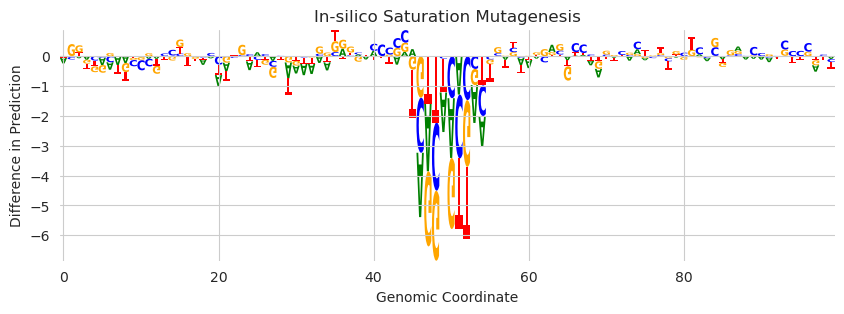

In [6]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(y_attr1[0, :, 950:1050, 267], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction")
plt.title("In-silico Saturation Mutagenesis")
plt.show()

We can see here that there are negative values for all of the character substitutions in the motif and much smaller values for the other characters. This means that the motif drives higher predictions in the AP-1 task because altering that motif yields smaller predictions, which makes sense because the presence of an AP-1 binding site should be associated with AP-1 binding.

However, this is not the most intuitive way to view these attributions. Usually, you want to see positive values at the actual characters that are driving activity rather than a stacked chart of many characters. A common way to do this is to subtract out the per-position mean and multiply by the original one-hot encodings. Doing this means that we will only have values for the observed characters and that these values will be, basically, the negative difference in predictions when using a different character. Put another way: here, high positive values mean more important, rather than large negative values.

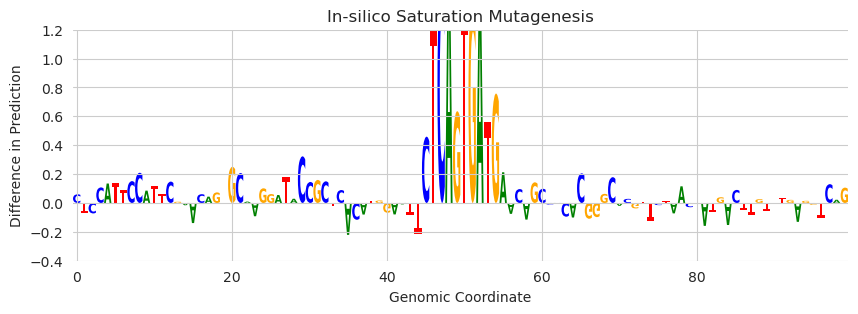

In [7]:
y_attr2 = (y_attr1 - y_attr1.mean(dim=1, keepdims=True)) * X.unsqueeze(-1)

plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(y_attr2[0, :, 950:1050, 267], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction")
plt.title("In-silico Saturation Mutagenesis")
plt.ylim(-0.4, 1.2)
plt.show()

If we look at a different task, like the binding of SP1, we can see that the model ignores the motif -- because it's not relevant for that task!

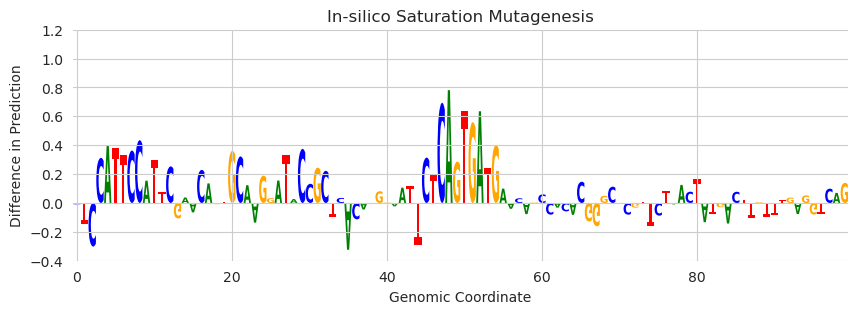

In [8]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(y_attr2[0, :, 950:1050, 278], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction")
plt.title("In-silico Saturation Mutagenesis")
plt.ylim(-0.4, 1.2)
plt.show()

If we wanted a more global view of attributions -- basically, asking the global effect that each nucleotide has on driving any task -- one might think to sum the attributions across all tasks. Given a small set of somewhat related tasks this might be a good idea, but for genomics models that have thousands of tasks that cover very correlated and anticorrelated activities, this can sometimes be a very bad idea because noise will dominate over all potential signal.

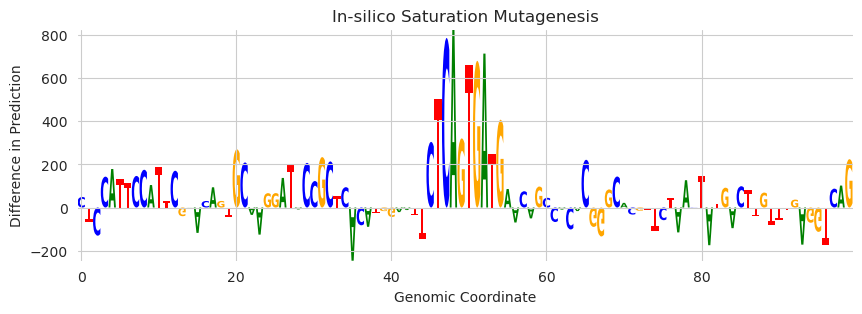

In [9]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_logo(y_attr2[0, :, 950:1050].sum(axis=-1), ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction")
plt.title("In-silico Saturation Mutagenesis")
plt.show()

Here, we can sort of make out the motif, but it's not nearly as clear as it is when looking at the original signal.

##### Windowed ISM

Sometimes, the sequences that you are evaluating are very long or there are too many of them and so you do not have the compute power to comprehensively run ISM everywhere. Other times, you have a small region of a sequence that is interesting and only want to focus on that window. For example, you may have a list of motif hits and you want to evaluate each one to see whether that motif is driving activity without having to waste time substitutions outside those motif hits. For both situations you may want to run ISM only on a portion of the input window instead of on everything. `saturated_mutagenesis` allows you to run ISM from only a start coordinate to an end coordinate and save time.

In [10]:
y_ref_w, y_ism_w = saturation_mutagenesis(model, X, start=950, end=1050, device='cpu')
y_ref_w.shape, y_ism_w.shape

(torch.Size([1, 2002]), torch.Size([1, 4, 100, 2002]))

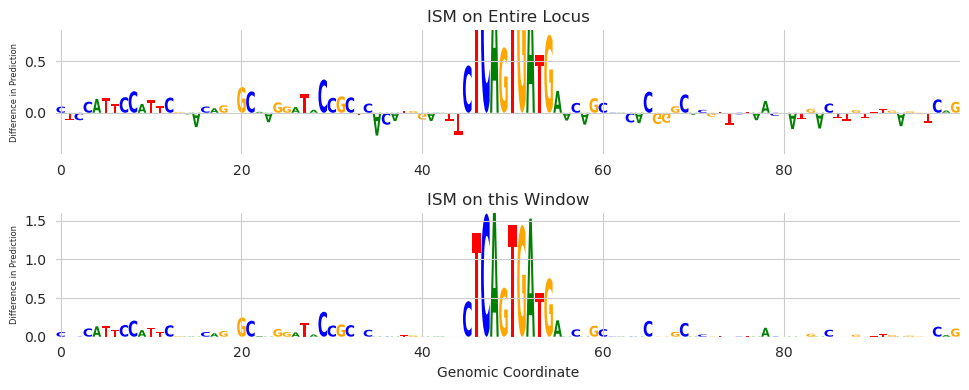

In [11]:
y_attr_w = y_ism_w - y_ref_w[:, None, None]
y_attr_w = (y_attr_w - y_attr_w.mean(dim=1, keepdims=True)) * X[:, :, 950:1050].unsqueeze(-1)

plt.figure(figsize=(10, 4))
ax = plt.subplot(211)
plot_logo(y_attr2[0, :, 950:1050, 267], ax=ax)
plt.ylim(0, 1.6)

plt.ylabel("Difference in Prediction", fontsize=6)
plt.title("ISM on Entire Locus")
plt.ylim(-0.4, 0.8)

ax = plt.subplot(212)
plot_logo(y_attr_w[0, :, :, 267], ax=ax)
plt.ylim(0, 1.6)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction", fontsize=6)
plt.title("ISM on this Window")

plt.tight_layout()
plt.show()

This functionality can also be easily adapted to assign a score for each of several potential regions of interest, such as scoring each motif from a simple motif scan to see whether it's a relevant hit.

In [12]:
import numpy
import pandas

starts = numpy.array([0, 990, 1090])
y_attr = []

for start in starts:
    end = start + 20

    y_ref_w, y_ism_w = saturation_mutagenesis(model, X, start=start, end=end, device='cpu')
    y_attr_w = y_ism_w - y_ref_w[:, None, None]
    y_attr_w = (y_attr_w - y_attr_w.mean(dim=1, keepdims=True)) * X[:, :, start:end].unsqueeze(-1)

    y_attr.append(y_attr_w[:, :, :, 267].sum().item())

df = pandas.DataFrame({'start': starts, 'end': starts+20, 'score': y_attr})
df

,start,end,score
0,0,20,0.006878
1,990,1010,11.293598
2,1090,1110,-1.016842


What we'd end up with, in this case, is a dataframe where the start and end specify the coordinates of the known motif (or region of interest) and the score is just the sum of the attribution values across all positions. Here, we can see that the second set of coordinates, which correspond to the window we know we inserted the motif, has the highest attribution sum. The other two sets of coordinates, which correspond to windows we know do not have the motif in it, have much smaller attribution sums.